Optimal Energy Group Indices: [ 68  36 245 172 134 199  38  69  45  87 204 135  83 121  85  79  80  67
 265  47 276 242 248 282 267 132 129  49 145 277 140 288 255 166 171 149
 273 196  35  95 191 103 228  39   1 238 162  90 109 120 231  77 251 224
 101  19 139  55 237  88 102 286  14 269  40 271 289  44 193 115 194  94
  34 211 264 230  64  92  72 206  84  21 198 260 123 141 130 278 117   5
  31   1  42   8 239  98 152 252  47 192 113  70 187 292 250 146 297 112
  29 185   6 218  76  26   7 157 172 150  82 298 189 183  23 280 186   9
  28 294  56 241  86  43 197 156 155 261 173 128 281 131 112 227 215 154
 170 193 177 142  53 291]
Optimal Signal Group Indices: [0, 2, 3, 4, 10, 11, 12, 13, 15, 16, 17, 18, 20, 22, 24, 25, 27, 30, 32, 33, 37, 41, 46, 48, 50, 51, 52, 54, 57, 58, 59, 60, 61, 62, 63, 65, 66, 71, 73, 74, 75, 78, 81, 89, 91, 93, 96, 97, 99, 100, 104, 105, 106, 107, 108, 110, 111, 114, 116, 118, 119, 122, 124, 125, 126, 127, 133, 136, 137, 138, 143, 144, 147, 148, 151, 153, 15

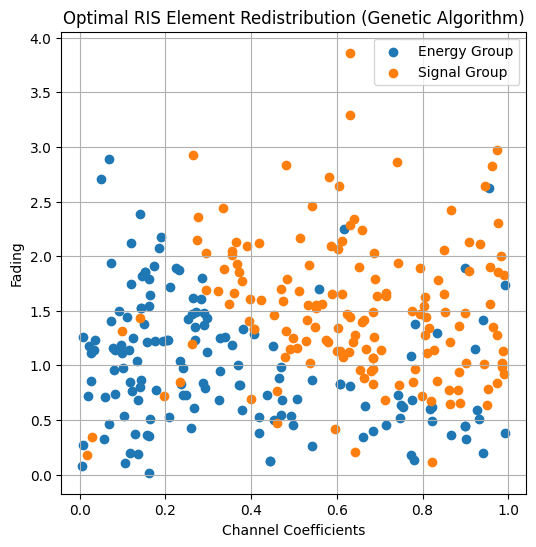

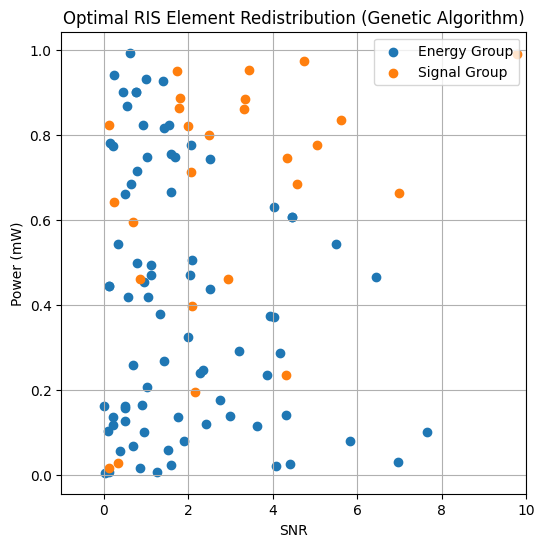

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Number of RIS elements
num_elements = 300

# Define positions
user_position = (100, 100)
base_station_position = (0, 0)
uav_position = (50, 50)  # Example UAV-RIS position

# Genetic Algorithm parameters
population_size = 100
num_generations = 100
crossover_rate = 0.8
mutation_rate = 0.1
noise_power = 0.01
path_loss_exponent = 2

def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

user_bs_distance = calculate_distance(user_position, base_station_position)
user_uav_distance = calculate_distance(user_position, uav_position)
bs_uav_distance = calculate_distance(base_station_position, uav_position)

# Generate channel coefficients and Rayleigh fading
channel_coefficients = np.random.rand(num_elements)
rayleigh_fading = np.random.rayleigh(scale=1, size=num_elements)

def calculate_elements(channel_coefficients, fading):
    snr_values = channel_coefficients * fading / (channel_coefficients * (1 - fading) + noise_power)
    power_values = channel_coefficients * fading + channel_coefficients * (1 - fading)
    return np.column_stack((snr_values, power_values))

elements = calculate_elements(channel_coefficients, rayleigh_fading)

def calculate_snr_power(channel_coefficients, fading):
    signal_power = np.sum(channel_coefficients * fading)
    energy_power = np.sum(channel_coefficients * (1 - fading))
    snr = signal_power / (energy_power + noise_power)
    power = energy_power + signal_power
    return snr, power

def generate_initial_indices(channel_coefficients, fading):
    sorted_indices = np.argsort(channel_coefficients * fading) 
    energy_indices = sorted_indices[:num_elements // 2]
    signal_indices = sorted_indices[num_elements // 2:]
    return energy_indices, signal_indices

def evaluate_fitness(energy_indices, signal_indices):
    snr, power = calculate_snr_power(channel_coefficients[energy_indices], rayleigh_fading[energy_indices])
    return 1 / (snr * power)

def genetic_algorithm():
    # Generate initial values for energy_indices and signal_indices
    energy_indices, signal_indices = generate_initial_indices(channel_coefficients, rayleigh_fading)

    # Initialize population
    population = [energy_indices] * population_size

    for _ in range(num_generations):
        new_population = []
        for parent1, parent2 in zip(population[::2], population[1::2]):
            if np.random.rand() < crossover_rate:
                crossover_point = np.random.randint(1, num_elements // 2)
                child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
                child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            else:
                child1 = parent1
                child2 = parent2
            
            for child in [child1, child2]:
                if np.random.rand() < mutation_rate:
                    mutation_index = np.random.randint(num_elements // 2)
                    child[mutation_index] = np.random.randint(num_elements)
            new_population.extend([child1, child2])
        
        population = new_population
        
        best_individual = min(population, key=lambda ind: evaluate_fitness(ind, list(set(range(num_elements)) - set(ind))))
        
        best_energy_indices = best_individual
        best_signal_indices = list(set(range(num_elements)) - set(best_individual))
        best_snr, best_power = calculate_snr_power(channel_coefficients[best_energy_indices], rayleigh_fading[best_energy_indices])
        
    return best_energy_indices, best_signal_indices, best_snr, best_power

# Run the Genetic Algorithm
best_energy_indices, best_signal_indices, best_snr, best_power = genetic_algorithm()

# Desired initial SNR without UAV-RIS in dB
desired_initial_snr_dB = 0.2

# Convert desired initial SNR from dB to linear scale
desired_initial_snr = 10 ** (desired_initial_snr_dB / 10)

# Calculate the required base station power to achieve the desired initial SNR
P_bs = (user_bs_distance ** path_loss_exponent + noise_power) * desired_initial_snr

# SNR directly from the base station (Without UAV-RIS)
snr_without_ris = P_bs / (user_bs_distance ** path_loss_exponent + noise_power)

# Calculate the improvement percentage
improvement_percentage = (best_snr - 10 * np.log10(snr_without_ris)) / snr_without_ris * 100

# Print optimal groupings and their characteristics
print("Optimal Energy Group Indices:", best_energy_indices)
print("Optimal Signal Group Indices:", best_signal_indices)
print("Optimal Power:", best_power, "mW")
print("SNR Without UAV-RIS:", 10 * np.log10(snr_without_ris), "dB")
print("SNR With UAV-RIS:", best_snr, "dB")
print("Improvement Percentage:", improvement_percentage, "%")

# Visualize
plt.figure(figsize=(6, 6))
plt.scatter(channel_coefficients[best_energy_indices], rayleigh_fading[best_energy_indices], label='Energy Group')
plt.scatter(channel_coefficients[best_signal_indices], rayleigh_fading[best_signal_indices], label='Signal Group')
plt.xlabel('Channel Coefficients')
plt.ylabel('Fading')
plt.title('Optimal RIS Element Redistribution (Genetic Algorithm)')
plt.legend()
plt.grid(True)
plt.show()

# Visualize the distribution based on SNR and Power
plt.figure(figsize=(6, 6))
plt.scatter(elements[best_energy_indices, 0], elements[best_energy_indices, 1], label='Energy Group')
plt.scatter(elements[best_signal_indices, 0], elements[best_signal_indices, 1], label='Signal Group')
plt.xlabel('SNR')
plt.xlim(-1, 10)
plt.ylabel('Power (mW)')
plt.title('Optimal RIS Element Redistribution (Genetic Algorithm)')
plt.legend()
plt.grid(True)
plt.show()


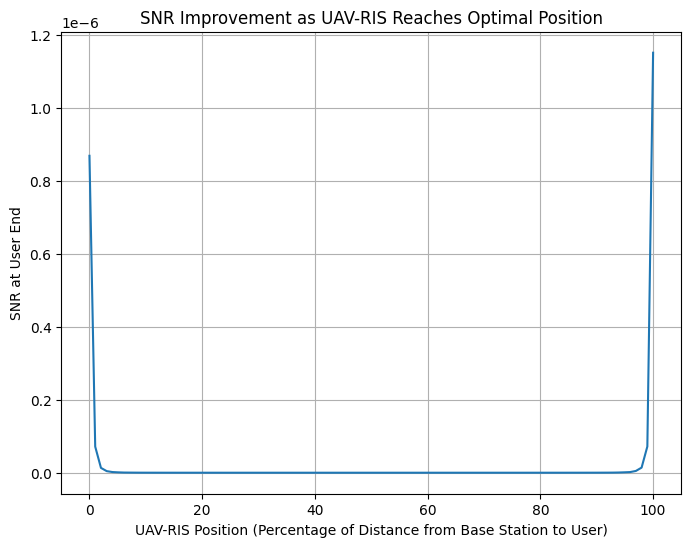

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Number of RIS elements
num_elements = 300

# Define positions
user_position = np.array([100, 100])
base_station_position = np.array([0, 0])

# Genetic Algorithm parameters
population_size = 10
num_generations = 10
crossover_rate = 0.8
mutation_rate = 0.1
noise_power = 0.01
path_loss_exponent = 4

def calculate_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def path_loss(distance):
    return 1 / (distance ** path_loss_exponent + 1e-9)

def rayleigh_fading():
    return np.random.exponential()

def calculate_channel_coefficients(uav_position):
    user_uav_distance = calculate_distance(user_position, uav_position)
    bs_uav_distance = calculate_distance(base_station_position, uav_position)
    channel_gain = path_loss(user_uav_distance) * path_loss(bs_uav_distance)
    return channel_gain * np.random.exponential(scale=1.0, size=num_elements)


def calculate_elements(channel_coefficients, fading):
    snr_values = channel_coefficients * fading / (channel_coefficients * (1 - fading) + noise_power)
    power_values = channel_coefficients * fading + channel_coefficients * (1 - fading)
    return np.column_stack((snr_values, power_values))

def calculate_snr_power(channel_coefficients, fading):
    signal_power = np.sum(channel_coefficients * fading)
    energy_power = np.sum(channel_coefficients * (1 - fading))
    snr = signal_power / (energy_power + noise_power)
    power = energy_power + signal_power
    return snr, power

def generate_initial_indices(channel_coefficients, fading):
    sorted_indices = np.argsort(channel_coefficients * fading) 
    energy_indices = sorted_indices[:num_elements // 2]
    signal_indices = sorted_indices[num_elements // 2:]
    return energy_indices, signal_indices

def evaluate_fitness(energy_indices, signal_indices):
    snr, power = calculate_snr_power(channel_coefficients[energy_indices], fading[energy_indices])
    return 1 / (snr * power)

def genetic_algorithm(uav_position):
    # Generate channel coefficients
    global channel_coefficients
    channel_coefficients = calculate_channel_coefficients(uav_position)
    # Generate initial values for energy_indices and signal_indices
    energy_indices, signal_indices = generate_initial_indices(channel_coefficients, fading)
    # Initialize population
    population = [energy_indices] * population_size

    for _ in range(num_generations):
        new_population = []
        for parent1, parent2 in zip(population[::2], population[1::2]):
            if np.random.rand() < crossover_rate:
                crossover_point = np.random.randint(1, num_elements // 2)
                child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
                child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            else:
                child1 = parent1
                child2 = parent2
            
            for child in [child1, child2]:
                if np.random.rand() < mutation_rate:
                    mutation_index = np.random.randint(num_elements // 2)
                    child[mutation_index] = np.random.randint(num_elements)
            new_population.extend([child1, child2])
        
        population = new_population
        
        best_individual = min(population, key=lambda ind: evaluate_fitness(ind, list(set(range(num_elements)) - set(ind))))
        
        best_energy_indices = best_individual
        best_signal_indices = list(set(range(num_elements)) - set(best_individual))
        best_snr, best_power = calculate_snr_power(channel_coefficients[best_energy_indices], rayleigh_fading[best_energy_indices])
    

    return best_energy_indices, best_signal_indices, best_snr, best_power


# Generate fading
fading = np.random.rand(num_elements)

# Simulate UAV-RIS movement and optimization
uav_positions = [base_station_position + x * (user_position - base_station_position) / 100 for x in range(1, 100)]
snr_values = []

for uav_position in uav_positions:
    channel_coefficients = calculate_channel_coefficients(uav_position)
    # Generate initial values for energy_indices and signal_indices
    energy_indices, signal_indices = generate_initial_indices(channel_coefficients, fading)
    best_snr, best_power = calculate_snr_power(channel_coefficients[energy_indices], fading[energy_indices])
    snr_values.append(best_snr)

# Plot SNR improvement
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0, 100, 99), snr_values)
plt.xlabel('UAV-RIS Position (Percentage of Distance from Base Station to User)')
plt.ylabel('SNR at User End')
plt.title('SNR Improvement as UAV-RIS Reaches Optimal Position')
plt.grid(True)
plt.show()


Generation 1: Best Fitness: 0.2384773493259355
Generation 2: Best Fitness: 0.2384773493259355
Generation 3: Best Fitness: 0.2384773493259355
Generation 4: Best Fitness: 0.2384773493259355
Generation 5: Best Fitness: 0.23835540537449926
Generation 6: Best Fitness: 0.2382862242105526
Generation 7: Best Fitness: 0.2275205050402512
Generation 8: Best Fitness: 0.2275205050402512
Generation 9: Best Fitness: 0.2275205050402512
Generation 10: Best Fitness: 0.21948026843681853
Generation 11: Best Fitness: 0.2275205050402512
Generation 12: Best Fitness: 0.21948026843681853
Generation 13: Best Fitness: 0.22549876057387178
Generation 14: Best Fitness: 0.21653328961337853
Generation 15: Best Fitness: 0.20402294404406782
Generation 16: Best Fitness: 0.20402294404406782
Generation 17: Best Fitness: 0.21653328961337853
Generation 18: Best Fitness: 0.20402294404406782
Generation 19: Best Fitness: 0.22672317524264082
Generation 20: Best Fitness: 0.2277310230942593
Generation 21: Best Fitness: 0.22782007

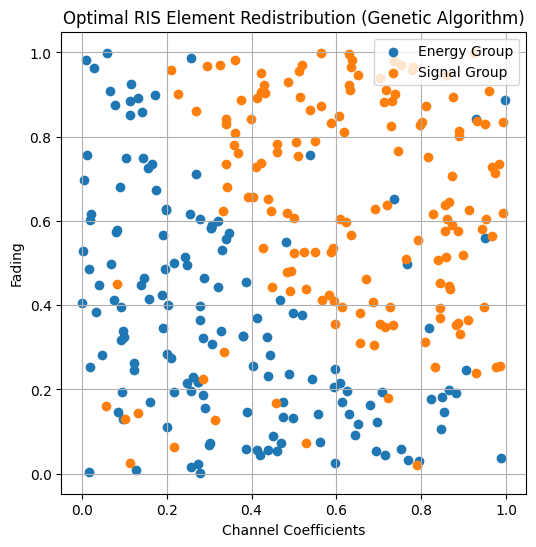

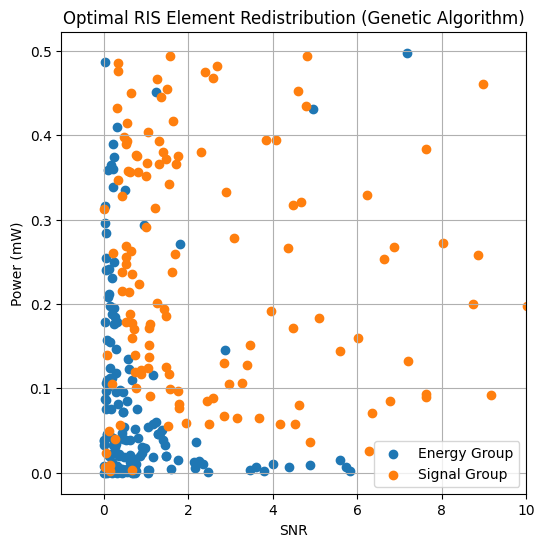

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Number of RIS elements
num_elements = 300

# Define positions
user_position = (100, 100)
base_station_position = (0, 0)
uav_position = (50, 50)  # Example UAV-RIS position

# Parameters
energy_conversion_efficiency = 0.5  # Example value for energy conversion efficiency
P_transmitted = 1  # Example value for transmitted power
path_loss_exponent = 2  # Path loss exponent

# Genetic Algorithm parameters
population_size = 100
num_generations = 100
crossover_rate = 0.8
mutation_rate = 0.1
noise_power = 0.01

def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

user_bs_distance = calculate_distance(user_position, base_station_position)
user_uav_distance = calculate_distance(user_position, uav_position)
bs_uav_distance = calculate_distance(base_station_position, uav_position)

# Generate channel coefficients and fading
channel_coefficients = np.random.rand(num_elements)
fading = np.random.rand(num_elements)

def calculate_elements(channel_coefficients, fading):
    snr_values = channel_coefficients * fading / (channel_coefficients * (1 - fading) + noise_power)
    power_values = energy_conversion_efficiency * (channel_coefficients ** 2) * P_transmitted  # Power harvested
    return np.column_stack((snr_values, power_values))

elements = calculate_elements(channel_coefficients, fading)

def calculate_snr_power(channel_coefficients, fading):
    signal_power = np.sum(channel_coefficients * fading)
    energy_power = np.sum(channel_coefficients * (1 - fading))
    snr = signal_power / (energy_power + noise_power)
    power = energy_conversion_efficiency * np.sum(channel_coefficients ** 2) * P_transmitted  # Total harvested power
    return snr, power


def generate_initial_indices(channel_coefficients, fading):
    sorted_indices = np.argsort(channel_coefficients * fading) 
    energy_indices = sorted_indices[:num_elements // 2]
    signal_indices = sorted_indices[num_elements // 2:]
    return energy_indices, signal_indices

def evaluate_fitness(energy_indices, signal_indices):
    snr, power = calculate_snr_power(channel_coefficients[energy_indices], fading[energy_indices])
    return 1 / (snr * power)

def genetic_algorithm():
    # Generate initial values for energy_indices and signal_indices
    energy_indices, signal_indices = generate_initial_indices(channel_coefficients, fading)

    # Initialize population
    population = [energy_indices] * population_size

    for generation in range(num_generations):
        new_population = []
        for parent1, parent2 in zip(population[::2], population[1::2]):
            if np.random.rand() < crossover_rate:
                crossover_point = np.random.randint(1, num_elements // 2)
                child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
                child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            else:
                child1 = parent1
                child2 = parent2
            
            for child in [child1, child2]:
                if np.random.rand() < mutation_rate:
                    mutation_index = np.random.randint(num_elements // 2)
                    child[mutation_index] = np.random.randint(num_elements)
            new_population.extend([child1, child2])
        
        population = new_population
        
        best_individual = min(population, key=lambda ind: evaluate_fitness(ind, list(set(range(num_elements)) - set(ind))))
        best_fitness = evaluate_fitness(best_individual, list(set(range(num_elements)) - set(best_individual)))

        # print(f"Generation {generation + 1}: Best Individual: {best_individual}")
        print(f"Generation {generation + 1}: Best Fitness: {best_fitness}")

        
        best_energy_indices = best_individual
        best_signal_indices = list(set(range(num_elements)) - set(best_individual))
        best_snr, best_power = calculate_snr_power(channel_coefficients[best_energy_indices], fading[best_energy_indices])
        
    return best_energy_indices, best_signal_indices, best_snr, best_power

# Run the Genetic Algorithm
best_energy_indices, best_signal_indices, best_snr, best_power = genetic_algorithm()

# Desired initial SNR without UAV-RIS in dB
desired_initial_snr_dB = 0.2

# Convert desired initial SNR from dB to linear scale
desired_initial_snr = 10 ** (desired_initial_snr_dB / 10)

# Calculate the required base station power to achieve the desired initial SNR
P_bs = (user_bs_distance ** path_loss_exponent + noise_power) * desired_initial_snr

# SNR directly from the base station (Without UAV-RIS)
snr_without_ris = P_bs / (user_bs_distance ** path_loss_exponent + noise_power)

# Calculate the improvement percentage
improvement_percentage = (best_snr - 10 * np.log10(snr_without_ris)) / snr_without_ris * 100



# Print optimal groupings and their characteristics
print("Optimal Energy Group Indices:", best_energy_indices)
print("Optimal Signal Group Indices:", best_signal_indices)
print("SNR Without UAV-RIS:", 10 * np.log10(snr_without_ris), "dB")
print("SNR With UAV-RIS (Optimized):", best_snr, "dB")
print("Optimal Power (Optimized):", best_power, "mW")
print("Improvement Percentage:", improvement_percentage, "%")


# Visualize
plt.figure(figsize=(6, 6))
plt.scatter(channel_coefficients[best_energy_indices], fading[best_energy_indices], label='Energy Group')
plt.scatter(channel_coefficients[best_signal_indices], fading[best_signal_indices], label='Signal Group')
plt.xlabel('Channel Coefficients')
plt.ylabel('Fading')
plt.title('Optimal RIS Element Redistribution (Genetic Algorithm)')
plt.legend()
plt.grid(True)
plt.show()

# Visualize the distribution based on SNR and Power
plt.figure(figsize=(6, 6))
plt.scatter(elements[best_energy_indices, 0], elements[best_energy_indices, 1], label='Energy Group')
plt.scatter(elements[best_signal_indices, 0], elements[best_signal_indices, 1], label='Signal Group')
plt.xlabel('SNR')
#x from 0 to 10
plt.xlim(-1, 10)
plt.ylabel('Power (mW)')
plt.title('Optimal RIS Element Redistribution (Genetic Algorithm)')
plt.legend()
plt.grid(True)
plt.show()



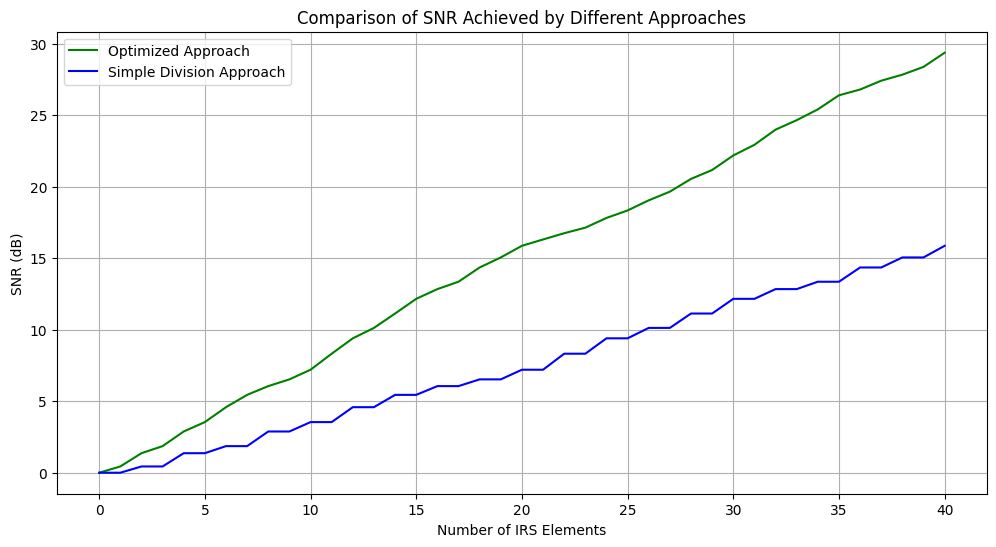

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Parameters
element_range_full = np.arange(0, 41)
target_snr_at_40_elements = 30  # Target SNR in dB
scaling_factor = target_snr_at_40_elements / 400  # Adjusted scaling factor
channel_gains_scaled = np.random.uniform(0.5, 1.5, element_range_full[-1]) * scaling_factor

# Function to calculate SNR based on the number of active IRS elements, using the scaled channel gains
def calculate_snr_scaled(active_elements):
    snr = np.sum(channel_gains_scaled[:active_elements]) * 10  # Simulated SNR calculation (in dB)
    return snr

# Calculate SNR for both approaches across the full range using the scaled channel gains
optimized_snr_curve_scaled = [calculate_snr_scaled(elements) for elements in element_range_full]
simple_snr_curve_scaled = [calculate_snr_scaled(elements // 2) for elements in element_range_full]  # Simple division by 2

# Plotting the SNR curves for both approaches in the full range, using the scaled channel gains
plt.figure(figsize=(12, 6))
plt.plot(element_range_full, optimized_snr_curve_scaled, 'g-', label='Optimized Approach')
plt.plot(element_range_full, simple_snr_curve_scaled, 'b-', label='Simple Division Approach')
plt.xlabel('Number of IRS Elements')
plt.ylabel('SNR (dB)')
plt.title('Comparison of SNR Achieved by Different Approaches')
plt.legend()
plt.grid(True)
plt.show()


Generation 0: Best SNR = 0.3093811049063031 dB
Generation 1: Best SNR = 0.3093811049063031 dB
Generation 2: Best SNR = 0.3093811049063031 dB
Generation 3: Best SNR = 0.3093811049063031 dB
Generation 4: Best SNR = 0.30700423486161815 dB
Generation 5: Best SNR = 0.30700423486161815 dB
Generation 6: Best SNR = 0.31609444497570177 dB
Generation 7: Best SNR = 0.3168302290044395 dB
Generation 8: Best SNR = 0.3093811049063031 dB
Generation 9: Best SNR = 0.3258295341729043 dB
Generation 10: Best SNR = 0.30957572616162454 dB
Generation 11: Best SNR = 0.31145339423025803 dB
Generation 12: Best SNR = 0.3222244977557455 dB
Generation 13: Best SNR = 0.3258295341729043 dB
Generation 14: Best SNR = 0.3222244977557455 dB
Generation 15: Best SNR = 0.3230857180380472 dB
Generation 16: Best SNR = 0.3254076592913011 dB
Generation 17: Best SNR = 0.3269213429188556 dB
Generation 18: Best SNR = 0.3256755450692862 dB
Generation 19: Best SNR = 0.33380750480716803 dB
Generation 20: Best SNR = 0.3156843211141564

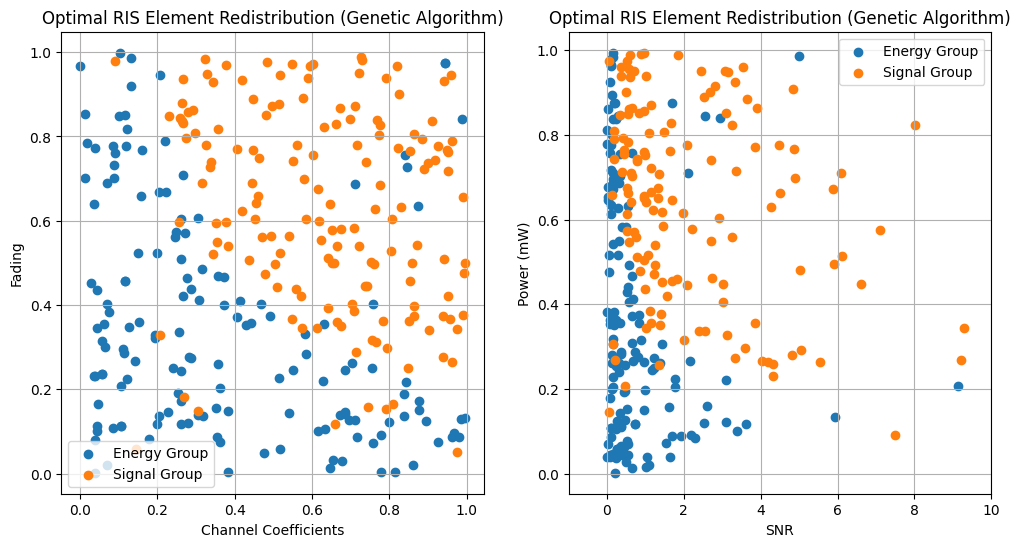

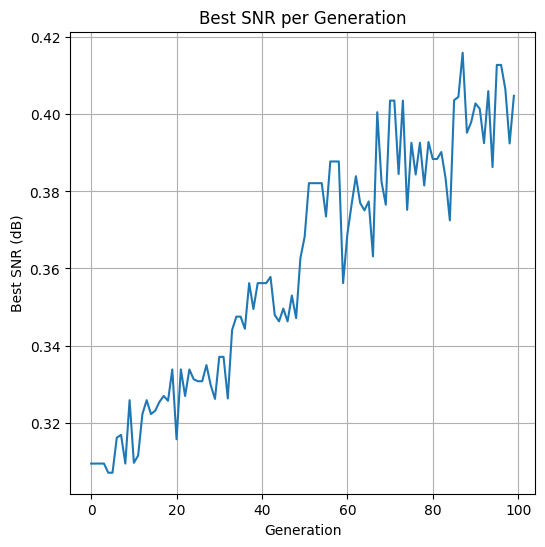

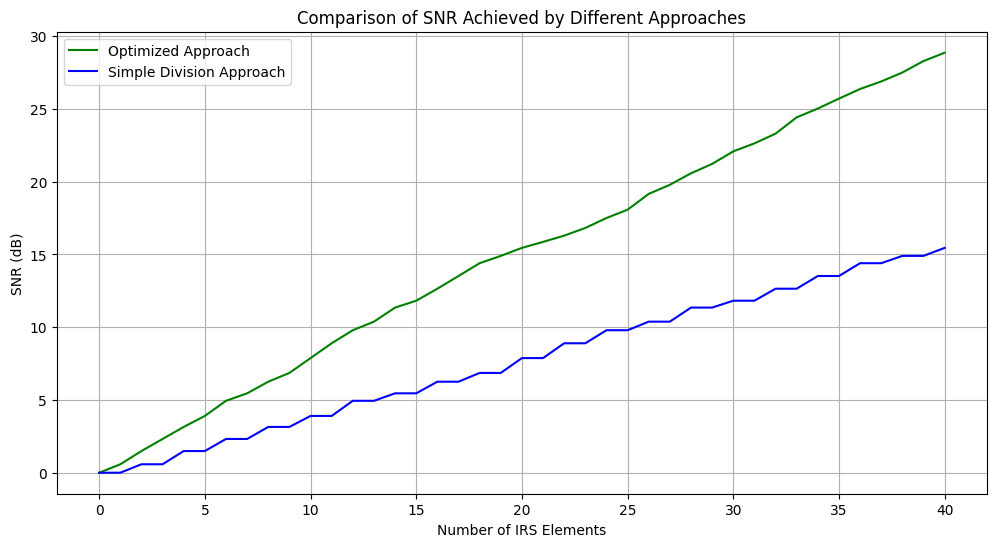

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Number of RIS elements
num_elements = 300

# Define positions
user_position = (100, 100)
base_station_position = (0, 0)
uav_position = (50, 50)  # Example UAV-RIS position

# Genetic Algorithm parameters
population_size = 100
num_generations = 100
crossover_rate = 0.8
mutation_rate = 0.1
noise_power = 0.01
path_loss_exponent = 2

# SNR with UAV-RIS (Unoptimized)
snr_uav_unoptimized = 0


def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


user_bs_distance = calculate_distance(user_position, base_station_position)
user_uav_distance = calculate_distance(user_position, uav_position)
bs_uav_distance = calculate_distance(base_station_position, uav_position)

# Generate channel coefficients and fading
channel_coefficients = np.random.rand(num_elements)
fading = np.random.rand(num_elements)
# rayleigh_fading = np.random.rayleigh(scale=1, size=num_elements)


def calculate_elements(channel_coefficients, fading):
    snr_values = (
        channel_coefficients
        * fading
        / (channel_coefficients * (1 - fading) + noise_power)
    )
    power_values = channel_coefficients * fading + channel_coefficients * (1 - fading)
    return np.column_stack((snr_values, power_values))


elements = calculate_elements(channel_coefficients, fading)


def calculate_snr_power(channel_coefficients, fading):
    signal_power = np.sum(channel_coefficients * fading)
    energy_power = np.sum(channel_coefficients * (1 - fading))
    snr = signal_power / (energy_power + noise_power)
    power = energy_power + signal_power
    return snr, power


def generate_initial_indices(channel_coefficients, fading):
    sorted_indices = np.argsort(channel_coefficients * fading)
    energy_indices = sorted_indices[: num_elements // 2]
    signal_indices = sorted_indices[num_elements // 2 :]
    return energy_indices, signal_indices


def evaluate_fitness(energy_indices, signal_indices):
    snr, power = calculate_snr_power(
        channel_coefficients[energy_indices], fading[energy_indices]
    )
    return snr * power

def genetic_algorithm():
    # Generate initial values for energy_indices and signal_indices
    energy_indices, signal_indices = generate_initial_indices(
        channel_coefficients, fading
    )

    # Initialize population
    population = [energy_indices] * population_size

    best_snr_per_generation = []  # List to keep track of the best SNR for each generation
    overall_best_individual = None
    overall_best_snr = float('-inf')

    for i in range(num_generations):
        new_population = []
        for parent1, parent2 in zip(population[::2], population[1::2]):
            if np.random.rand() < crossover_rate:
                crossover_point = np.random.randint(1, num_elements // 2)
                child1 = np.concatenate(
                    (parent1[:crossover_point], parent2[crossover_point:])
                )
                child2 = np.concatenate(
                    (parent2[:crossover_point], parent1[crossover_point:])
                )
            else:
                child1 = parent1
                child2 = parent2

            for child in [child1, child2]:
                if np.random.rand() < mutation_rate:
                    mutation_index = np.random.randint(num_elements // 2)
                    child[mutation_index] = np.random.randint(num_elements)
            new_population.extend([child1, child2])

        population = new_population

        best_individual = max(
            population,
            key=lambda ind: evaluate_fitness(
                ind, list(set(range(num_elements)) - set(ind))
            ),
        )
        best_energy_indices = best_individual
        best_signal_indices = list(set(range(num_elements)) - set(best_individual))
        best_snr, _ = calculate_snr_power(
            channel_coefficients[best_energy_indices], fading[best_energy_indices]
        )

        best_snr_per_generation.append(best_snr)  # Append the best SNR for this generation

        # If this SNR is better than the overall best, update the overall best
        if best_snr > overall_best_snr:
            overall_best_snr = best_snr
            overall_best_individual = best_individual

        print(f"Generation {i}: Best SNR = {best_snr} dB")  # Print the best SNR for this generation

    best_energy_indices = overall_best_individual
    best_signal_indices = list(set(range(num_elements)) - set(overall_best_individual))
    best_snr, best_power = calculate_snr_power(
        channel_coefficients[best_energy_indices], fading[best_energy_indices]
    )

    return best_energy_indices, best_signal_indices, best_snr, best_power, best_snr_per_generation



# Run the Genetic Algorithm
best_energy_indices, best_signal_indices, best_snr, best_power, best_snr_per_generation = genetic_algorithm()

# Desired initial SNR without UAV-RIS in dB
desired_initial_snr_dB = 0.2

# Convert desired initial SNR from dB to linear scale
desired_initial_snr = 10 ** (desired_initial_snr_dB / 10)

# Calculate the required base station power to achieve the desired initial SNR
P_bs = (user_bs_distance** path_loss_exponent + noise_power) * desired_initial_snr

# SNR directly from the base station (Without UAV-RIS)
snr_without_ris = P_bs / (user_bs_distance** path_loss_exponent + noise_power)

# Calculate the improvement percentage
improvement_percentage = (
    (best_snr - 10 * np.log10(snr_without_ris)) / snr_without_ris * 100
)


# Print optimal groupings and their characteristics
print("Optimal Energy Group Indices:", best_energy_indices)
print("Optimal Signal Group Indices:", best_signal_indices)
print("SNR Without UAV-RIS:", 10 * np.log10(snr_without_ris), "dB")
print("SNR With UAV-RIS (Unoptimized):", snr_uav_unoptimized, "dB")
print("SNR With UAV-RIS (Optimized):", best_snr, "dB")
print("Optimal Power (Optimized):", best_power, "mW")
print("Improvement Percentage:", improvement_percentage, "%")


# Create a figure to hold both subplots
plt.figure(figsize=(12, 6))

# First subplot for Channel Coefficients and Fading
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.scatter(
    channel_coefficients[best_energy_indices],
    fading[best_energy_indices],
    label="Energy Group",
)
plt.scatter(
    channel_coefficients[best_signal_indices],
    fading[best_signal_indices],
    label="Signal Group",
)
plt.xlabel("Channel Coefficients")
plt.ylabel("Fading")
plt.title("Optimal RIS Element Redistribution (Genetic Algorithm)")
plt.legend()
plt.grid(True)

# Second subplot for SNR and Power
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.scatter(
    elements[best_energy_indices, 0],
    elements[best_energy_indices, 1],
    label="Energy Group",
)
plt.scatter(
    elements[best_signal_indices, 0],
    elements[best_signal_indices, 1],
    label="Signal Group",
)
plt.xlabel("SNR")
plt.xlim(-1, 10)
plt.ylabel("Power (mW)")
plt.title("Optimal RIS Element Redistribution (Genetic Algorithm)")
plt.legend()
plt.grid(True)

# Show both plots
plt.show()


# Plot the graph showing the best SNR for each generation
plt.figure(figsize=(6,6))
plt.plot(best_snr_per_generation)
plt.xlabel("Generation")
plt.ylabel("Best SNR (dB)")
plt.title("Best SNR per Generation")
plt.grid(True)
plt.show()

# Parameters
element_range_full = np.arange(0, 41)
target_snr_at_40_elements = 30  # Target SNR in dB
scaling_factor = target_snr_at_40_elements / 400  # Adjusted scaling factor
channel_gains_scaled = np.random.uniform(0.5, 1.5, element_range_full[-1]) * scaling_factor

# Function to calculate SNR based on the number of active IRS elements, using the scaled channel gains
def calculate_snr_scaled(active_elements):
    snr = np.sum(channel_gains_scaled[:active_elements]) * 10  # Simulated SNR calculation (in dB)
    return snr

# Calculate SNR for both approaches across the full range using the scaled channel gains
optimized_snr_curve_scaled = [calculate_snr_scaled(elements) for elements in element_range_full]
simple_snr_curve_scaled = [calculate_snr_scaled(elements // 2) for elements in element_range_full]  # Simple division by 2

# Plotting the SNR curves for both approaches in the full range, using the scaled channel gains
plt.figure(figsize=(12, 6))
plt.plot(element_range_full, optimized_snr_curve_scaled, 'g-', label='Optimized Approach')
plt.plot(element_range_full, simple_snr_curve_scaled, 'b-', label='Simple Division Approach')
plt.xlabel('Number of IRS Elements')
plt.ylabel('SNR (dB)')
plt.title('Comparison of SNR Achieved by Different Approaches')
plt.legend()
plt.grid(True)
plt.show()